# Programming Exercise 2: Logistic Regression
*Code's author: Natália Tenório Maia*<br>
*Solution for [Exercise 2](https://www.coursera.org/learn/machine-learning/home/week/3) of Coursera's Machine Learning course by Andrew Ng.*
<br>
<br>
There are many different ways to solve this exercise. Here you will learn just one possible way, where I tried to stick with the original idea proposed in the exercise's pdf.
<br>
<br>
In this exercise, we will implement logistic regression and apply it to two different datasets.

## Part 1 - Logistic regression
In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university.
Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant’s scores on two exams and the admissions decision. <br>
**Goal:** Your task is to build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams.
<br>
Steps:<br>
1 - Import data; <br>
2 - Visualize data;<br>
3 - Implement the sigmoid and the cost function;<br>
4 - Fit parameters; <br>
5 - Make prediction.<br>
### Importing data

In [1]:
import numpy as np               # package for scientific computing
import matplotlib.pyplot as plt  # plotting library
from scipy import optimize       # package for optimizing functions

In [2]:
# Loading dataset:
dataset = np.loadtxt('ex2data1.txt', delimiter=',')

m = len(dataset)                                      # number of examples
X = np.append(np.ones((m,1)), dataset[:,:2], axis=1)  # training input mx3 matrix
y = dataset[:,2].reshape(-1,1)                        # training output mx1 vector

### Visualizing data

Let's split the whole dataset into two subgroups: those who got admitted and those who got rejected. This will allow for a better visualization of the training dataset, as shown below.

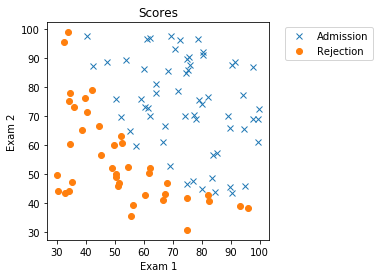

In [3]:
admissions = dataset[dataset[:,2]==1]; rejections = dataset[dataset[:,2]==0]
ax = plt.subplot()
plt.plot(admissions[:,0],admissions[:,1],'x',label='Admission')
plt.plot(rejections[:,0],rejections[:,1],'o',label='Rejection')
plt.title('Scores'); plt.xlabel('Exam 1'); plt.ylabel('Exam 2')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_xticks(np.arange(30,110,10));ax.set_yticks(np.arange(30,110,10))
plt.gca().set_aspect('equal', adjustable='box')

### Implementing functions

The logistic regression hypothesis is given by <br>
$$
h_{\theta}=g\left(X\theta\right)
$$ <br>
where $g$ is the sigmoid function <br>
$$
g\left(X\theta\right)=\frac{1}{1+e^{-X\theta}}.
$$<br>
The logistic regression cost function and its gradient are <br>
$$
J\left(\theta\right)=-\frac{1}{m}\sum_{i=1}^{m}\left[y^{(i)}log\left(h_{\theta}\left(x^{(i)}\right)\right)+\left(1-y^{(i)}\right)log\left(1-h_{\theta}\left(x^{(i)}\right)\right)\right],
$$
$$
\theta_{j}=\theta_{j}-\frac{\alpha}{m}\sum_{i=1}^{m}\left(h_{\theta}\left(x^{\left(i\right)}\right)-y^{\left(i\right)}\right)x_{j}^{\left(i\right)},
$$

with $j=0,...,k$, where $k$ is the number of features, and with $\alpha$ being the learning rate. In the **vectorized format**, which is the one we use in this notebook, they are given as follows:
$$
J\left(\theta\right)=-\frac{1}{m}\left[y^{T}log\left(h_{\theta}\right)+\left(1-y^{T}\right)log\left(1-h_{\theta}\right)\right],
$$

$$
\theta=\theta-\frac{\alpha}{m}X^{T}\left(h_{\theta}-y\right).
$$

In [4]:
# Simplified matrix multiplication command:
def MM(A,B):
    return np.matmul(A,B)
    
# Logistic regression hypothesis or sigmoid function:
def sigmoid(theta,X):
    theta = theta.reshape(-1,1)
    return 1/(1+np.exp(-MM(X,theta)))

# Cost function:
def costfunction(theta,X,y):
    theta = theta.reshape(-1,1)
    h = 1/(1+np.exp(-MM(X,theta)))
    J = -(1/m)*(MM(y.T,np.log(h))+MM((1-y.T),np.log(1-h)))
    grad = ((1/m)*MM((X.T),(h-y))).flatten()
    return float(J), grad

Let's now perform the test proposed in the file ex2.m. The results below agree with those presented in that file:

In [5]:
print("First check:");
theta = np.zeros(X.shape[1]); J, grad = costfunction(theta,X,y); print(J); print(grad[:5])
print("Second check:");
#theta = np.array([[-24],[0.2],[0.2]]); print(J(theta,X,y)[0]); print(J(theta,X,y)[1][:5])
theta = np.array([-24,0.2,0.2]); J, grad = costfunction(theta,X,y); print(J); print(grad[:5])

First check:
0.6931471805599452
[ -0.1        -12.00921659 -11.26284221]
Second check:
0.2183301938265977
[0.04290299 2.56623412 2.64679737]


### Learning parameters using scipy.optimize

We want to optimize the parameters $\theta$ in order to minimize the cost function $J(\theta)$.

SciPy optimize provides functions for minimizing (or maximizing) objective functions, possibly subject to constraints.<br>
Lib: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None) <br>
We will give the following arguments: <br>
* fun: the function costfunction we defined above;
* x0: the array for the initial values of $\theta$ has to be given in the format (n,);
* args: additional variables of the costfunction, which in this case is the training dataset X,y;
* method: the two different optimizing methods which work well for this costfunction are 'TNC' and ’Nelder-Mead’;
* jac: this is True if our cost function provides its gradient, None if not;
* options: we don't have to give options necessarily, but we will limit the maximum number of iterations anyway just to make sure we get the result quickly.

OBS: The method=’Nelder-Mead’ works well and does not require defining the gradient of the cost function. But in fact, it will only work if the function costfunction returns a single value: the cost function. However, as we already defined the costfunction as a function returning two values, i.e. the cost and its gradient, we will choose method='TNC', which will enable us to set jac=True when using our costfunction in optimize.minimize(), as shown below.

In [6]:
# Initial theta:
initial_theta = np.zeros((X.shape[1]))

# Optimizing function:
optmin = optimize.minimize(costfunction,initial_theta,(X,y),jac=True,method='TNC',options={'maxiter': 100})

J = optmin.fun
theta = optmin.x
J, theta

(0.2034977015894742, array([-25.1613187 ,   0.20623159,   0.20147149]))

The results above agree with those in the file ex2.m .

### Prediction
Now that everything looks good, let's predict whether a particular student will be admitted or not. For a student with an Exam 1 score of 45 and an Exam 2 score of 85, let's predict what is the admission probability:

In [7]:
Xnew = np.array([[1,45,85]])
Prob = sigmoid(theta,Xnew)
Prob

array([[0.77629062]])

The result above tells us that this student has 77.6% chance of being admitted in the university. This is in accordance with exercise's sheet, ex2.pdf. <br>

A way to evaluate the quality of the parameters we have found is to see how well the learned model predicts on our training set.

Our prediction, however, must be specific: it must say wheter students gets admitted or not. We follow this convention: 1 for admission (chances higher or equal to 50%), 0 for rejection (chances bellow 50%). Thus, instead of generating a column vector whose entries are probabilities, let's now write a vector whose entries are predictions:

In [8]:
# Let's see how well we are predicting the values of y that we use to train the model:
def prediction(theta,X):
    pred = np.array([1 if i>=0.5 else 0 for i in sigmoid(theta,X)]).reshape(-1,1)
    return pred
p = prediction(theta,X)
p[:4]

array([[0],
       [0],
       [0],
       [1]])

In [9]:
# Accuracy score:
np.mean(p == y)

0.89

In [10]:
# Alternatively, we could have used this other command:
from sklearn.metrics import accuracy_score
accuracy_score(p,y)

0.89

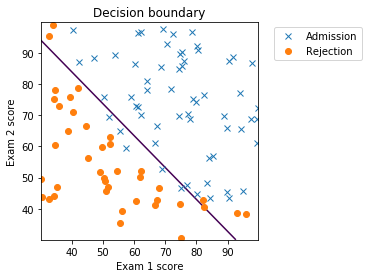

In [11]:
# Now let's plot the decision boundary:
ax = plt.subplot()
plt.plot(admissions[:,0],admissions[:,1],'x',label='Admission')
plt.plot(rejections[:,0],rejections[:,1],'o',label='Rejection')
plt.title('Decision boundary'); plt.xlabel('Exam 1 score'); plt.ylabel('Exam 2 score')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_xticks(np.arange(30,110,10));ax.set_yticks(np.arange(30,110,10))
plt.gca().set_aspect('equal', adjustable='box')

x1 = np.linspace(X[:,1].min(),X[:,1].max(),50); x2=x1; z = np.zeros((len(x1),len(x2)))
for i in range(len(x1)):
    for j in range(len(x2)):
        x = np.array([[1,x1[i],x2[j]]])
        z[i,j] = MM(x,theta)
plt.contour(x1, x2, z.T, levels=[0]);                                         

## Part 2 - Regularized logistic regression

In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.<br>
Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. <br>
**Goal:** From these two tests, you would like to determine whether the microchips should be accepted or rejected. 
### Importing data

In [12]:
dataset2 = np.loadtxt('ex2data2.txt',delimiter=',')
dataset2[:2,:]

array([[ 0.051267,  0.69956 ,  1.      ],
       [-0.092742,  0.68494 ,  1.      ]])

In [13]:
m = len(dataset2)
X = dataset2[:,:2] # Let's not add the x0 column yet. We'll do this later.
y = dataset2[:,2].reshape(-1,1)

This dataset seems already normalized, so we don't need to worry about performing feature scaling.
### Visualizing data

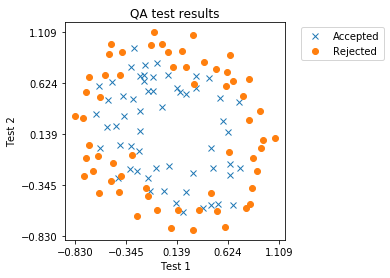

In [14]:
# In order to have a meaninful plot, let divide the data into
# two subgroups: good chips and defective chips.
def PlotData():
    Good = dataset2[dataset2[:,2]==1]
    Defect = dataset2[dataset2[:,2]==0]
    ax = plt.subplot()
    plt.plot(Good[:,0],Good[:,1],'x',label='Accepted')
    plt.plot(Defect[:,0],Defect[:,1],'o',label='Rejected')
    plt.title("QA test results"); plt.xlabel("Test 1"); plt.ylabel("Test 2");
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left'); plt.gca().set_aspect('equal', adjustable='box');
    ax.set_xticks(np.linspace(Defect.min(),Defect.max(),5));ax.set_yticks(np.linspace(Defect.min(),Defect.max(),5));
PlotData()

Differently from the previous section, a straight line is not a good choice for a decision boundary in this present case. An eleptical-like decision boundary would be better suited for the graph above. We might need to use the features x1 and x2 (related to test 1 and test 2 results, respectively) to design more features in order improve the shape of the decision boundary and, consequently, to improve the accuracy of our model.
### Creating more features

This code below provides a way to append new values to an array by using its existing entries w and z:

In [15]:
import sympy                     # package for handling non-numerical mathematical variables
w,z = sympy.symbols(('w', 'z')); # variables
M = np.array([[w,z]]);           # initial array whose entries are w and z
d=6                              # maximum degree of possible polinomial combinations
for i in np.arange(1,d,1):
    val1 = w**(i+1); val2 = z**(i+1)
    M = np.append(M,np.array([[val1]]),axis=1); M = np.append(M,np.array([[val2]]),axis=1)
for i in np.arange(1,d+1,1):
    for j in np.arange(1,i,1):
        val3 = (w**j) * (z**(i-j))
        M = np.append(M,np.array([[val3]]),axis=1)
print(M.shape)
M

(1, 27)


array([[w, z, w**2, z**2, w**3, z**3, w**4, z**4, w**5, z**5, w**6, z**6,
        w*z, w*z**2, w**2*z, w*z**3, w**2*z**2, w**3*z, w*z**4,
        w**2*z**3, w**3*z**2, w**4*z, w*z**5, w**2*z**4, w**3*z**3,
        w**4*z**2, w**5*z]], dtype=object)

The process of using the existing features to create new ones is called *Feature Mapping*. Following the idea shown above, the function below takes the 2 features of the initial training dataset X and multiply them in order to generate additional feautures. This multiplication is such that the hypothesis will be described by a polynomial of degree 6:

In [16]:
# Feature mapping function for a 2x2 matrix X:
def FM(X,d):
    M = X
    for n in range(X.shape[1]):
        for i in np.arange(1,d,1):
            vals = (X[:,n]**(i+1)).reshape(-1,1);
            M = np.append(M,vals,axis=1)
    for i in np.arange(1,d+1,1):
        for j in np.arange(1,i,1):
            vals = ((X[:,0]**j).reshape(-1,1))*((X[:,1]**(i-j)).reshape(-1,1)); 
            M = np.append(M,vals,axis=1)
    return M
# This is our initial input training set:
X = dataset2[:,:2]
# Our new input training set will be given by the extended matrix M generated
# by the feature mapping function plus the x0 column which we insert by hand: 
M = FM(X,6)
X = np.append(np.ones((m,1)), M, axis=1)
X.shape

(118, 28)

A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot. While the feature mapping allows us to build a more expressive classifier, it also more susceptible to overfitting. In the next parts of the exercise, we will implement regularized logistic regression to fit the data and also see for ourselves how regularization can help combat the overfitting problem.
### Implementing regularized cost function 

Regularized cost function for logistic regression:

$$
J\left(\theta\right)=-\frac{1}{m}\sum_{i=1}^{m}\left[y^{(i)}log\left(h_{\theta}\left(x^{(i)}\right)\right)+\left(1-y^{(i)}\right)log\left(1-h_{\theta}\left(x^{(i)}\right)\right)\right]+\frac{\lambda}{2m}\sum_{j}^{k}\theta_{j}^{*2},
$$

where $\theta^{*}$ is equal to $\theta$ but **excluding** $\theta_{0}$. The gradient is:
\begin{align*}
\theta_{0} & =\theta_{0}-\alpha\frac{1}{m}\sum_{i=1}^{m}\left(h_{\theta}\left(x^{\left(i\right)}\right)-y^{\left(i\right)}\right)x_{0}^{\left(i\right)}\\
\theta_{j} & =\theta_{j}\left(1-\alpha\frac{\lambda}{m}\right)-\alpha\frac{1}{m}\sum_{i=1}^{m}\left(h_{\theta}\left(x^{\left(i\right)}\right)-y^{\left(i\right)}\right)x_{j}^{\left(i\right)}
\end{align*}

for $j\neq0$.

In [17]:
# Regularized cost function:
def costfunction_reg(theta,X,y,lamb):
    theta = theta.reshape(-1,1)
    sumtheta=0
    for i in np.arange(1,len(theta),1):
        sumtheta = sumtheta + theta[i]**2
    h = 1/(1+np.exp(-MM(X,theta)))
    J = -(1/m)*(MM(y.T,np.log(h))+MM((1-y.T),np.log(1-h)))+(lamb/(2*m))*sumtheta
    thetamod = np.append([0],theta[1:len(theta)]).reshape(-1,1)
    grad = ((1/m)*MM((X.T),(h-y))+(lamb/m)*thetamod).flatten()
    return float(J), grad

Let's now perform the tests proposed in the file ex2_reg.m. But for that, we're going to use the non-normalized matrix M that we obtained after performing the feature mapping.

In [18]:
theta = np.zeros((X.shape[1],1)); J, grad = costfunction_reg(theta,X,y,1);
g1 = [np.round(float(i),4) for i in grad]; print(J, g1[:5])
theta = np.ones((X.shape[1],1)); J, grad = costfunction_reg(theta,X,y,10);
g2 = [np.round(float(i),4) for i in grad]; print(J, g2[:5])

0.6931471805599453 [0.0085, 0.0188, 0.0001, 0.0503, 0.0184]
3.16450933161501 [0.346, 0.1614, 0.1948, 0.2269, 0.1434]


The results above agree with those shown in ex2_reg.m, with the exception of the last terms 0.0184 and 0.1434. The reason is: the order in which I added the extra features in my codes is different from that in the file mapFeature.m . The fifth value of the gradient of the cost function in that code is equivalent to the thirteenth value of my gradient function, as you can see below. Therefore, my results and those of ex2_reg.m are not equal but equivalent.

In [19]:
print(g1[13], g2[13])

0.0115 0.0922


### Learning parameters and plotting decision boundaries

In [20]:
def PlotDecisionBoundary():
    x1 = np.linspace(X[:,1].min()-0.1,X[:,1].max()+0.1,50); x2=x1; z = np.zeros((len(x1),len(x2)))
    for i in range(len(x1)):
        for j in range(len(x2)):
            pair = np.array([[x1[i],x2[j]]]) # pair of points in the grid
            xnew = FM(pair,6)                # feature mapping
            x = np.append([[1]],xnew,axis=1) # adding the unit value
            z[i,j] = MM(x,theta)
    plt.contour(x1, x2, z.T, levels=[0]);

Let's plot decision boundaries for different values of lambda: 0, 1 and 100.

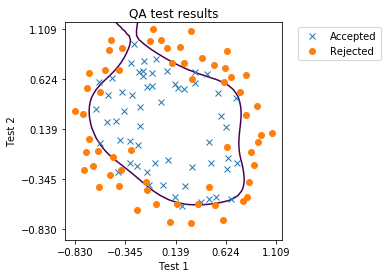

In [21]:
lamb = 0
initial_theta = np.zeros((X.shape[1]))
optmin = optimize.minimize(costfunction_reg,initial_theta,(X,y,lamb),jac=True,method='TNC',options={'maxiter': 100})
J = optmin.fun; theta = optmin.x

PlotData()
PlotDecisionBoundary()

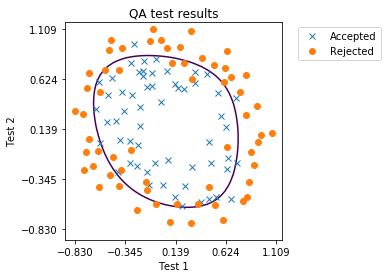

In [22]:
lamb = 1
initial_theta = np.zeros((X.shape[1]))
optmin = optimize.minimize(costfunction_reg,initial_theta,(X,y,lamb),jac=True,method='TNC',options={'maxiter': 100})
J = optmin.fun; theta = optmin.x

PlotData()
PlotDecisionBoundary()

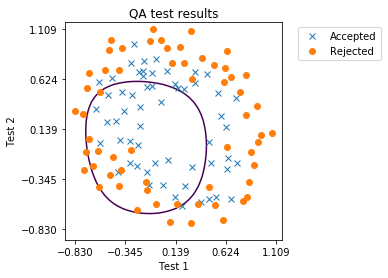

In [23]:
lamb = 100
initial_theta = np.zeros((X.shape[1]))
optmin = optimize.minimize(costfunction_reg,initial_theta,(X,y,lamb),jac=True,method='TNC',options={'maxiter': 100})
J = optmin.fun; theta = optmin.x

PlotData()
PlotDecisionBoundary()

These different decision boundaries allow us to see how the choice of the regularization parameter lambda affects the accuracy of our result. For a null lambda, lamb=0, the model shows clear overfitting. On the other hand, if lalmbda is too large, lamb=100, the model underfits. The choice lamb=1 seems to be a good one.<br>
OBS: I also noticed that by changing the maximim number of iterations in optimize.minimize() the accuracy of the model can also be affected.

### Prediction

In [24]:
# Good choice for lambda:
lamb = 1
initial_theta = np.zeros((X.shape[1]))
optmin = optimize.minimize(costfunction_reg,initial_theta,(X,y,lamb),jac=True,method='TNC',options={'maxiter': 100})
J = optmin.fun; theta = optmin.x

p = prediction(theta,X)

In [25]:
# Accuracy score:
np.mean(p == y).round(2)

0.83

This means our model got 83% of the results in the training set right. This agrees with file ex2_reg.m .

End of the exercise 2.